In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'

In [10]:
## Functions
def A(x, R, dr, periodic, a0):
    a = np.ones(x.shape[:-1])
    if periodic:
        return a
    
    norm = np.linalg.norm(x, axis=1) # X is of shape (N, 2)
    envlope = R - dr
    
    if (norm > R).any():
        raise ValueError
    
    idx = (norm <= R) & (norm >= envlope)
    a[idx] = np.exp(-a0 * ((norm[idx] - envlope) / dr)**2)
    
    return a

def f(x):
    x[x < 0] = 0
    return x

In [11]:
def plot_state_vs_time(s, fig_r=5, fig_c=5):
    T = s.shape[0]
    n = int(np.sqrt(s.shape[1]))
    s_ = s.reshape((T, n, n))

    
    dt = T / (fig_r * fig_c)
    fig, ax = plt.subplots(fig_r, fig_c, figsize=(10, 10))
    for i, j in product(range(fig_r), range(fig_c)):
        t = int(dt * (i * fig_c + j))
        ax[i, j].imshow(s_[t], origin='lower')
        ax[i, j].set_title(t)
    fig.tight_layout()

In [35]:
class Simulation:
    def __init__(self, n, m, l, a, gamma, beta, c, periodic, print_param=True):
        if print_param:
            print('n = %d' % n,
                  'm = %d' % m,
                  'l = %.2f' % l,
                  'a = %.2f' % a, 
                  'gamma = %.2f' % gamma, 
                  'beta = %.2f' % beta, 
                  'periodic %s' % periodic, 
                  'c = %.2f' % c, sep='\n')
        
        self.N, self.M = n * n, m * m
        self.n, self.m = n, m
        self.l = l
        self.a, self.gamma, self.beta = a, gamma, beta
        
        self.periodic = periodic

        # preferred directions
        self.theta = np.linspace(0, 2 * np.pi, num=self.M, endpoint=False)
        e = np.zeros((n, n))
        for i in range(n//m):
            for j in range(n//m):
                np.random.shuffle(self.theta)
                e[i*m:(i+1)*m, j*m:(j+1)*m] = self.theta.reshape((m, m))
        # unit vector corresponding to the directions
        self.e = np.stack((np.cos(e), np.sin(e)), axis=-1).reshape((self.N, 2))

        # Neuron locations
        _ = np.linspace(-n/2, n/2, num=n, endpoint=False)
        self.x = np.stack(np.meshgrid(_, _), axis=2).reshape((self.N, 2))
    
        if not periodic:
            loc = self.x - l * self.e
            W = np.linalg.norm(loc[None, ...] - self.x[:, None, :], axis=-1)**2
#             for i in range(self.N):
#                 mi, mj = (i // n) % m, (i % n) % m
#                 loc = self.x[i] - l * self.e[mi * m + mj]
#                 W[:, i] = np.linalg.norm(loc[None, :] - self.x, axis=1)**2
                
        else:
            loc = self.x - l * self.e
            W = np.abs(loc[None, ...] - self.x[:, None, :])
            W[W > n/2] = n - W[W > n/2]
#             W[W[..., 0] > n/2, 0] = n - W[W[..., 0] > n/2, 0]
#             W[W[..., 1] > n/2, 1] = n - W[W[..., 1] > n/2, 1]
            W = np.linalg.norm(W, axis=-1)**2
#             for i in range(self.N):
#                 mi, mj = (i // n) % m, (i % n) % m
#                 loc = self.x[i] - l * self.e[mi * m + mj]
#                 dist_x = np.abs(loc[0] - self.x[:, 0])
#                 dist_y = np.abs(loc[1] - self.x[:, 1])
#                 dist_x[dist_x > n/2] = n - dist_x[dist_x > n/2]
#                 dist_y[dist_y > n/2] = n - dist_y[dist_y > n/2]
                
#                 W[:, i] = np.linalg.norm(np.stack((dist_x, dist_y), axis=1), axis=1)**2

        self.W = c * (a * np.exp(-gamma * W) - np.exp(-beta * W))
    
    def __call__(self, alpha, T, tau, v, f,
                 R, dr, a0, 
                 s_init=None, spiking=False, print_param=True):
        
        if print_param:
            print('alpha = %.2f' % alpha, 
                  'T = %d' % T, 
                  'tau = %d' % tau, 
                  'R = %d' % R, 
                  'dr = %d' % dr, 
                  'a0 = %.2f' % a0, sep='\n')
        
        s = np.zeros((T, self.N))
        if s_init is not None:
            s[0] = s_init
        
        spike = np.zeros((T, self.N)) if spiking else None
            
        
        b = np.zeros(self.N)

        for t in range(1, T):
            A_all = A(self.x, R, dr, self.periodic, a0) 
            b = (1 + alpha * self.e @ v[t]) * A_all
#             for i in range(self.N):
#                 mi, mj = (i // self.n) % self.m, (i % self.n) % self.m
#                 b[i] = (1 + alpha * np.dot(self.e[mi * self.m + mj], v[t])) \
#                        * A_all[i]

            p = f(self.W @ s[t-1] + b)
            
            if spiking:
                rnd = np.random.rand(self.N)
                
                spike[t] = (rnd <= p).astype(np.int32)
                
                s[t, rnd <= p] = s[t-1, rnd <= p] + 1
                
                ds = -s[t-1, rnd > p]
                s[t, rnd > p] = s[t-1, rnd > p] + ds / tau
            else:
                ds = -s[t-1] + p
                s[t] = s[t-1] + ds / tau
                
        return s, b, spike

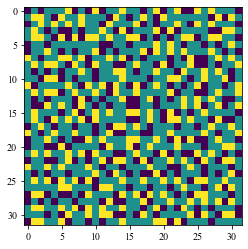

In [36]:
m = 2
theta = np.linspace(0, 2 * np.pi, num=4, endpoint=False)
e = np.zeros((n, n))
for i in range(n//m):
    for j in range(n//m):
        np.random.shuffle(theta)
        e[i*m:(i+1)*m, j*m:(j+1)*m] = theta.reshape((m, m))
# unit vector corresponding to the directions
e = np.stack((np.cos(e), np.sin(e)), axis=-1).reshape((32*32, 2))
plt.imshow((e @ np.array([0, 1])).reshape((32, 32)))

In [183]:
theta = np.linspace(0, 2 * np.pi, num=4, endpoint=False).reshape((2, 2))
# unit vector corresponding to the directions
e = np.stack((np.cos(theta), np.sin(theta)), axis=-1)
e[1, 0]

array([-1.0000000e+00,  1.2246468e-16])

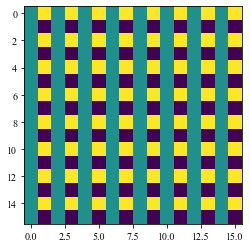

In [146]:
theta = np.linspace(0, 2 * np.pi, num=4, endpoint=False).reshape((2, 2))
# unit vector corresponding to the directions
e = np.stack((np.cos(theta), np.sin(theta)), axis=-1)
# e /= np.linalg.norm(e, axis=-1)[..., None]
e = np.tile(e, (8, 8, 1)).reshape((16*16, 2))
plt.imshow((e @ np.array([0, 1])).reshape((16, 16)))

In [14]:
n = 32
R = 32
dr = 32
periodic = True
a0 = 20
if not periodic:
    x = np.linspace(-n/2, n/2, num=15, endpoint=True)
    x = np.stack(np.meshgrid(x, x), axis=2).reshape((225, 2))
    plt.imshow(A(x, R, dr, periodic=periodic, a0=a0).reshape((15, 15)))

n = 32
m = 2
l = 0.50
a = 1.00
gamma = 0.08
beta = 0.06
periodic True
c = 1.00


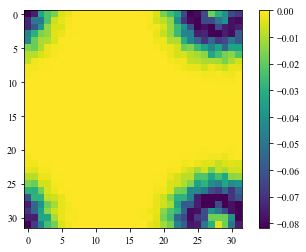

In [17]:
x = np.linspace(-n/2, n/2, endpoint=True)
x2 = x**2
a = 1.
lam = 4
beta = 1/lam**2
gamma = 1.25 * beta
c = 1
n = 32
sim1 = Simulation(n=n, m=2, l=0.5, a=a, beta=beta, gamma=gamma, c=c, periodic=periodic)
plt.imshow(sim1.W[1020].reshape((n, n)))
plt.colorbar()

n = 32
m = 2
l = 0.50
a = 1.00
gamma = 0.08
beta = 0.06
periodic True
c = 1.00
alpha = 0.00
T = 3000
tau = 10
R = 32
dr = 32
a0 = 20.00


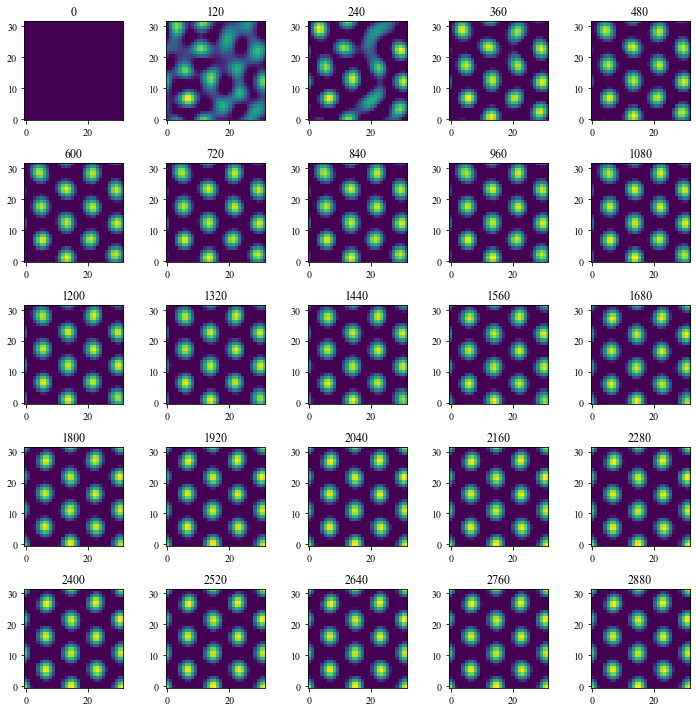

In [25]:
T = 3000

v = np.zeros((T, 2))


sim = Simulation(n=n, m=2, l=0.5, a=a, beta=beta, gamma=gamma, c=c, 
                 periodic=periodic)
s, b, spike = sim(alpha=0, T=T, tau=10, v=v, f=f, 
                  R=R, dr=dr, a0=a0, spiking=False)

plot_state_vs_time(s)

Static (no motion)
n = 32
m = 2
l = 0.50
a = 1.00
gamma = 0.08
beta = 0.06
periodic True
c = 0.10
alpha = 0.00
T = 3000
tau = 10
R = 32
dr = 32
a0 = 20.00


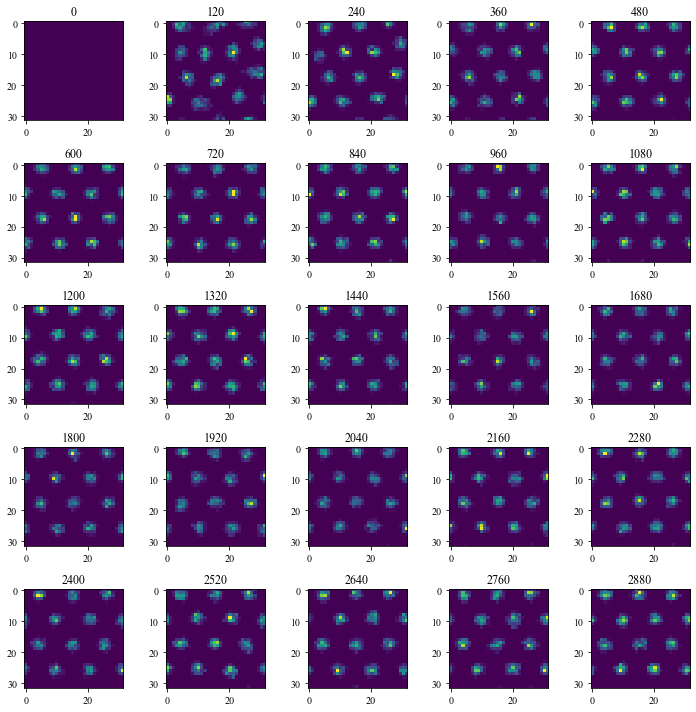

In [66]:
T = 3000

v = np.zeros((T, 2))

print('Static (no motion)')

sim = Simulation(n=n, m=2, l=0.5, a=a, beta=beta, gamma=gamma, c=0.1, periodic=periodic)
s, b, spike = sim(alpha=0, T=T, tau=10, v=v, f=f, 
                  R=R, dr=dr, a0=a0, spiking=True)
plot_state_vs_time(s)

Static (no motion)


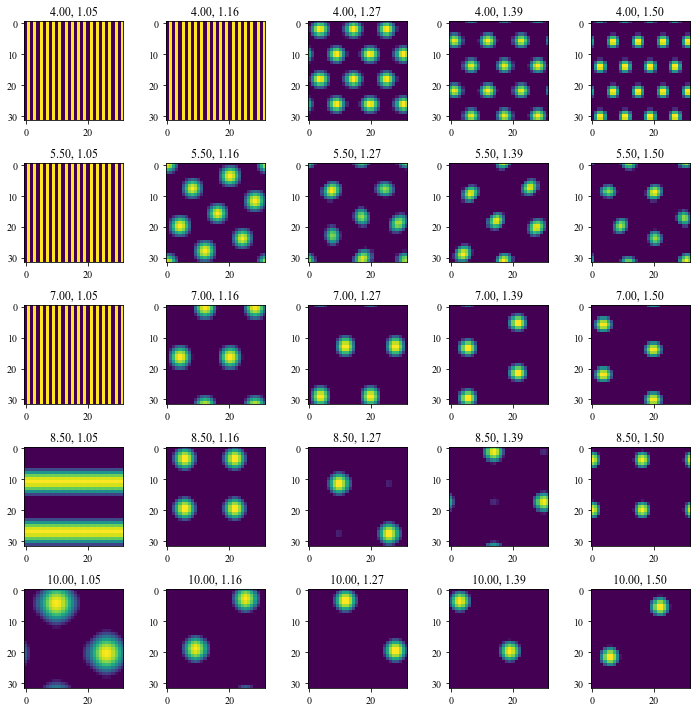

In [9]:
T = 3000

v = np.zeros((T, 2))

print('Static (no motion)')

p = np.linspace(4, 10, num=5)
q = np.linspace(1.05, 1.5, num=5)

count = 0
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in p:
    for j in q:
        beta = 1/(i**2)
        gamma = j * beta

        sim = Simulation(n=n, m=2, l=0.5, a=a, beta=beta, gamma=gamma, c=c, 
                         periodic=periodic, print_param=False)
        s, b, spike = sim(alpha=0, T=T, tau=10, v=v, f=f, 
                          R=R, dr=dr, a0=a0, print_param=False)
        
        ax[count//5, count%5].imshow(s[-1].reshape(n, n))
        ax[count//5, count%5].set_title('%.2f, %.2f' % (i, j))
        
        count += 1
        
fig.tight_layout()

In [26]:
s_init = s[-1]

In [69]:
maxi, maxj = np.where(s[-1].reshape((n, n)) == s[-1].max())
maxi, maxj = maxi[0], maxj[0]
maxi, maxj

(9, 31)

n = 32
m = 2
l = 0.50
a = 1.00
gamma = 0.08
beta = 0.06
periodic True
c = 1.00
alpha = 0.10
T = 1500
tau = 5
R = 32
dr = 32
a0 = 20.00
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[

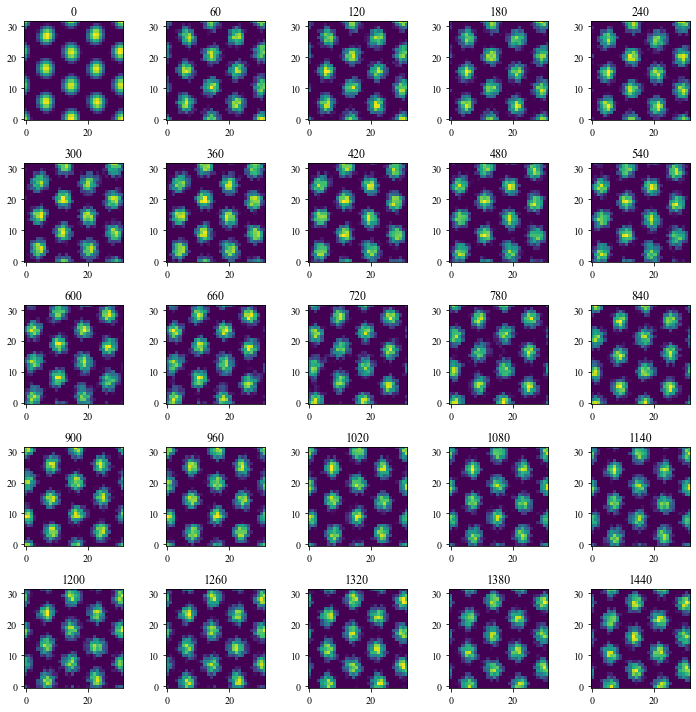

In [31]:
def f(x):
    x[x < 0] = 0
    return x

T = 1500

v = np.zeros((T, 2))
v[:, :] = [0.5, 0.5]

sim = Simulation(n=n, m=2, l=0.5, a=a, beta=beta, gamma=gamma, c=1, periodic=periodic)
s, b, spike = sim(alpha=0.1, T=T, tau=5, v=v, f=f, 
                  R=R, dr=dr, a0=a0, 
                  s_init=s_init, spiking=False)
plot_state_vs_time(s)

1
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401


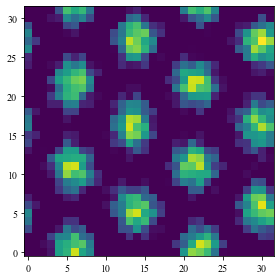

In [34]:
import matplotlib.animation
from IPython.display import HTML

def anim(s):
    T = s.shape[0]
    n = int(np.sqrt(s.shape[1]))
    s_ = s.reshape((T, n, n))

    fig, ax = plt.subplots()
    im = ax.imshow(s_[1], origin='lower')

    def animate(i):
        print(i)
        im.set_data(s_[i])
        im.autoscale()
        return [im]
    
    fig.tight_layout()

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=np.arange(1, T, 100))
    
    return ani
HTML(anim(s).to_jshtml())

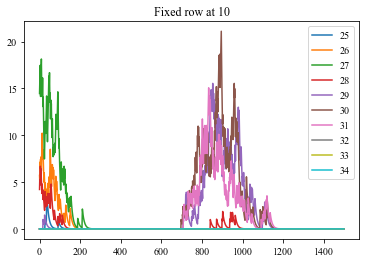

In [63]:
for j in range(30 - 5, 30 + 5):
    plt.plot(s_[:, maxi, j], label=j)
plt.title('Fixed row at %d' % maxi)
plt.legend()